# Tensorflow 2 on CoCalc

This shows some examples from the [migration guide](https://www.tensorflow.org/alpha/guide/migration_guide).

To get TF2 in Cocalc:

- Select "New Project..." → "Advanced ..." → "Custom Software" → scroll down to **"Tensorflow 2"**

Hint: This project also support code formatting!

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-rc0'

In [2]:
import tensorflow_datasets as tfds

In [3]:
W = tf.Variable(tf.ones(shape=(2, 2)), name="W")
b = tf.Variable(tf.zeros(shape=(2)), name="b")


@tf.function
def forward(x):
    return W * x + b


out_a = forward([1, 0])
print(out_a)

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


# Estimator: Linear Model

Shamelessly copied from https://www.tensorflow.org/alpha/tutorials/estimators/linear

In [4]:
# make matplotlib prettier
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [6]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
import pandas as pd

<h5 style="background-color:red; color:white; padding: 5px">Loading data reqires that your project has access to the internet</h5>

In [7]:
# Load dataset
dftrain = pd.read_csv(
    'https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv(
    'https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

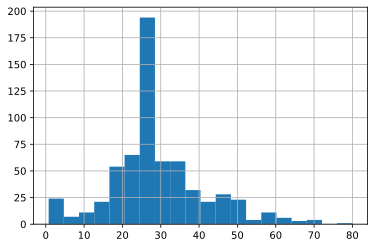

In [8]:
dftrain.age.hist(bins=20)

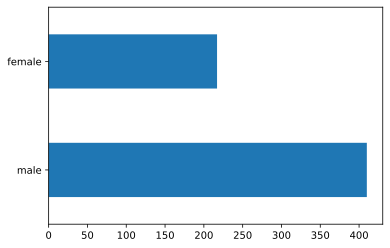

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

In [10]:
CATEGORICAL_COLUMNS = [
    'sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town',
    'alone'
]

NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [11]:
def make_input_fn(data_df,
                  label_df,
                  num_epochs=10,
                  shuffle=True,
                  batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds

    return input_function


train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [12]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'Third' b'Second' b'First' b'Third' b'First'
 b'Third' b'First']

A batch of Labels: [0 0 0 0 0 1 0 1 0 0]


In [13]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[47.],
       [40.],
       [28.],
       [28.],
       [18.],
       [60.],
       [24.],
       [35.],
       [22.],
       [61.]], dtype=float32)

In [14]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([
    tf.feature_column.indicator_column(gender_column)
])(feature_batch).numpy()

W0706 10:01:13.695795 140667409536832 deprecation.py:323] From /srv/conda/envs/notebook/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0706 10:01:13.700002 140667409536832 deprecation.py:323] From /srv/conda/envs/notebook/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0706 10:01:13.700935 140667409536832 deprecation.py:323] From /srv/conda/envs/notebook/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4270: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.83039486, 'auc_precision_recall': 0.77159166, 'average_loss': 0.50849754, 'label/mean': 0.375, 'loss': 0.49981472, 'precision': 0.72727275, 'prediction/mean': 0.28824264, 'recall': 0.56565654, 'global_step': 200}


In [16]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'],
                                                hash_bucket_size=100)

In [17]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns +
                                           derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.84762776, 'auc_precision_recall': 0.79725146, 'average_loss': 0.4671647, 'label/mean': 0.375, 'loss': 0.45873976, 'precision': 0.6956522, 'prediction/mean': 0.39844975, 'recall': 0.64646465, 'global_step': 200}


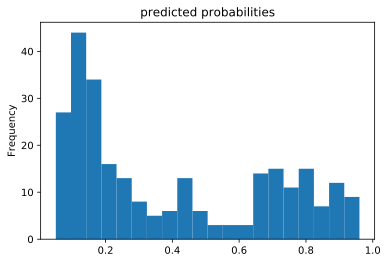

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.05)

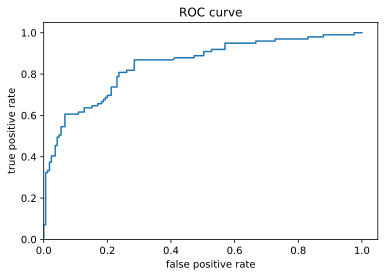

In [19]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0, )
plt.ylim(0, )